# PART 1: Dimensionality Reduction with PCA

In [78]:
import os
import numpy as np
import pandas as pd
from PIL import Image

In [79]:
# Opening images and storing their data for part 1 
filenames = []
images_data = []

for filename in os.listdir("Dataset1"):
    if filename.endswith(".bmp"):
        filenames.append(filename)
        image = Image.open(os.path.join("Dataset1", filename)).convert("L")
        image_data = np.array(image).flatten()
        images_data.append(image_data)

In [80]:
# Function for performing PCA
def pca(images_data):
    M = np.column_stack(images_data)

    mean_vector = np.mean(M, axis=0)

    D = M - mean_vector

    cov = np.dot(D.T, D)

    eigen_values, eigen_vectors = np.linalg.eig(cov)

    eigenvalue_indices = np.argsort(eigen_values)[::-1]
    eigenvectors = eigen_vectors[:, eigenvalue_indices]

    n = 3
    S = eigenvectors[:, :n]

    I = np.dot(D, S)

    return np.dot(I.T, D)

result_data = pca(images_data)
results1 = { "1": result_data[0], "2": result_data[1], "3": result_data[2]}

# Showing PCA results
results1_df = pd.DataFrame(results1, index=filenames)
results1_df

,1,2,3
Aligned_Fighter01.bmp,1.920196e+09,-7.462418e+07,-2.389750e+07
Aligned_Fighter02.bmp,1.875451e+09,-1.837600e+08,6.629510e+06
Aligned_Fighter03.bmp,1.917985e+09,-1.741338e+08,-2.898517e+06
Aligned_Fighter04.bmp,1.950215e+09,-9.934382e+07,-5.408618e+07
Aligned_Fighter05.bmp,1.988639e+09,5.339705e+07,5.123364e+06
Aligned_Fighter06.bmp,1.989529e+09,1.050900e+08,-2.106981e+07
Aligned_Fighter07.bmp,1.942380e+09,1.136463e+08,-1.372266e+07
Aligned_Fighter08.bmp,1.972561e+09,1.139160e+08,-6.283123e+07
Aligned_Fighter09.bmp,1.854960e+09,3.212966e+06,1.206376e+08
Aligned_Fighter10.bmp,1.960876e+09,1.055072e+08,3.242261e+07


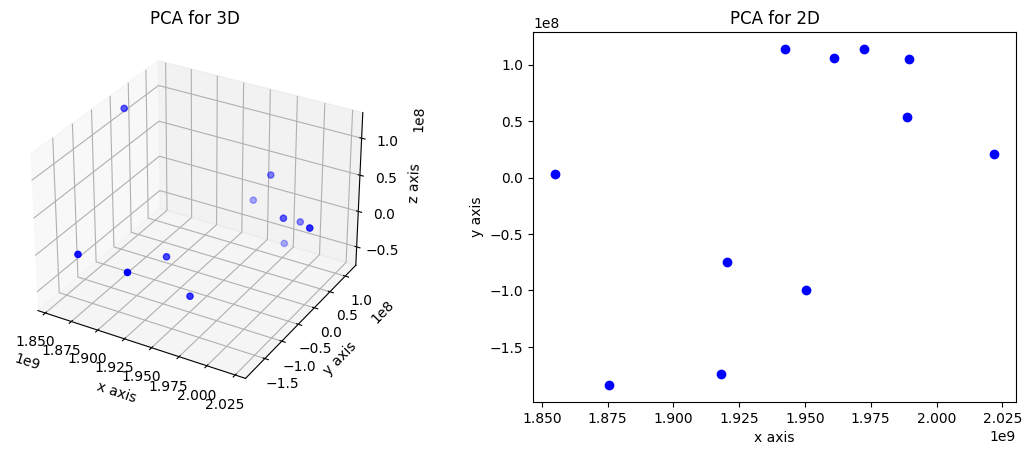

In [81]:
# Plotting PCA results in 3D and 2D plots

import matplotlib.pyplot as plt

fig= plt.figure(figsize=plt.figaspect(0.35))

ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(result_data[0, :], result_data[1, :], result_data[2, :], c='b', marker='o')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.set_title("PCA for 3D")


ax = fig.add_subplot(1,2,2)
ax.scatter(result_data[0, :], result_data[1, :], c='b', marker='o')
ax.set_title('PCA for 2D')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')


plt.show()

# PART 2: Image Retrieval with Color Histogram

In [82]:
from sklearn.cluster import KMeans

#Defining necessary functions for performing color histogram
def custom_histogram(data, bins=64, range=(0, 255)):
    # Calculate the bin width
    bin_width = (range[1] - range[0]) / bins

    # Initialize histogram bins
    histogram = [0] * bins

    # Iterate over data and update histogram
    for value in data:
        if range[0] <= value < range[1]:
            bin_index = int((value - range[0]) // bin_width)
            histogram[bin_index] += 1

    return histogram

def color_histogram(image):
    image = image.convert('RGB')

    # Getting pixel values for R, G, and B channels
    pixelsR = list(image.split()[0].getdata())
    pixelsG = list(image.split()[1].getdata())
    pixelsB = list(image.split()[2].getdata())

    # Calculating histograms for each channel
    histR = custom_histogram(pixelsR)
    histG = custom_histogram(pixelsG)
    histB = custom_histogram(pixelsB)

    # Normalize histograms
    histR_sum = sum(histR)
    histG_sum = sum(histG)
    histB_sum = sum(histB)

    histR = [value / histR_sum if histR_sum != 0 else 0 for value in histR]
    histG = [value / histG_sum if histG_sum != 0 else 0 for value in histG]
    histB = [value / histB_sum if histB_sum != 0 else 0 for value in histB]

    # Concatenate the histograms
    histogram = np.array(histR + histG + histB)
    
    return histogram


# Calculating euclidean distance
def distance(hist1, hist2):
    return np.linalg.norm(hist1 - hist2)

# Getting 10 closest distance
def get_ranked_list(query_filename, class_hist, query_hist):
    distances = []
    for (classname, filename), features in class_hist.items():
        dist = distance(query_hist[query_filename], features)
        distances.append((classname, filename, dist))
    
    distances.sort(key=lambda x: x[2])
    top_10_ranks = distances[:10]
    return top_10_ranks



# Function for k-means algorithm
def kmeans_clustering(features, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    return kmeans.labels_


# Functions for calculating MAP
def calculate_average_precision(retrieved, relevant):
    if len(relevant) == 0: return 0

    count = 0
    precision_sum = 0

    for k, item in enumerate(retrieved):
        if item in relevant:
            count += 1
            precision_at_k = count / (k + 1)
            precision_sum += precision_at_k

    return precision_sum / len(relevant)

def calculate_map(class_name, ranked_lists):
    average_precision_values = []
    for _ , ranked_list in ranked_lists.items():
        relevant = []
        retrieved = []
        
        for classname, filename, _ in ranked_list:
            if classname == class_name:
                if filename not in relevant:
                    relevant.append(filename)
            retrieved.append(filename)
        average_precision = calculate_average_precision(retrieved, relevant)
        average_precision_values.append(average_precision)
    
    if len(average_precision_values) == 0: return 0
    MAP = sum(average_precision_values) / len(average_precision_values)
    return MAP

In [83]:
# Opening 300 class images, extracting their histogram features and storing them
histogram_features = []
class_names = []
class_filenames = []
class_images = []
class_histogram = {}

for folder in os.listdir("Dataset2"):
    folder_path = os.path.join("Dataset2", folder)
    if os.path.isdir(folder_path) and folder != "QUERY_IMAGES":
        class_names.append(folder)
        for filename in os.listdir(folder_path):
            if filename.endswith(".jpg"):
                class_filenames.append([filename,folder])
                class_image = Image.open(os.path.join(folder_path, filename))
                class_images.append(class_image)

                class_hist = color_histogram(class_image)
                class_histogram[(folder, filename)] = class_hist.reshape(1, -1)
                
                histogram_features.append(class_hist)


# Same process on query images
query_histogram_features = []
query_filenames = []
query_images = []
query_histogram = {}

folder_path = os.path.join("Dataset2", "QUERY_IMAGES")
for filename in os.listdir(folder_path):
    if filename.endswith(".jpg"):
        query_filenames.append(filename)
        query_image = Image.open(os.path.join(folder_path, filename))
        query_images.append(query_image)

        query_hist = color_histogram(query_image)
        query_histogram[filename] = query_hist.reshape(1, -1)

        query_histogram_features.append(query_hist)


In [84]:
# Getting top 10 ranks for every query image and showing
ranked_lists = {}

for query_filename in query_filenames:
    ranked_lists[query_filename] = get_ranked_list(query_filename, class_histogram, query_histogram)

ranked_lists_df = pd.DataFrame(ranked_lists)

ranked_lists_df

,airplane_251_0175.jpg,airplane_251_0186.jpg,bear_009_0100.jpg,bear_009_0101.jpg,blimp_014_0015.jpg,blimp_014_0017.jpg,bonsai_015_0031.jpg,bonsai_015_0048.jpg,cactus_025_0010.jpg,cactus_025_0017.jpg,dog_056_0040.jpg,dog_056_0066.jpg,goat_085_0002.jpg,goat_085_0004.jpg,goose_089_0063.jpg,goose_089_0069.jpg,ibis_114_0046.jpg,ibis_114_0047.jpg,iris_118_0052.jpg,iris_118_0061.jpg
0,"(blimp, 014_0085.jpg, 0.21982689857104878)","(airplane, 251_0186.jpg, 0.0)","(cactus, 025_0088.jpg, 0.10082062132510669)","(googse, 089_0080.jpg, 0.20529932097800482)","(bear, 009_0082.jpg, 0.40931820612129377)","(dog, 056_0034.jpg, 0.1505317383411676)","(bonsai, 015_0025.jpg, 0.12847754794731261)","(bonsai, 015_0047.jpg, 0.04466854395177425)","(cactus, 025_0108.jpg, 0.18760266360790637)","(bonsai, 015_0035.jpg, 0.21104072051965397)","(bonsai, 015_0054.jpg, 0.16266260256679632)","(cactus, 025_0088.jpg, 0.08561874996706575)","(iris, 118_0044.jpg, 0.13358599946190242)","(ibis, 114_0015.jpg, 0.24846446559143634)","(airplane, 251_0253.jpg, 0.16547846769936816)","(iris, 118_0037.jpg, 0.09143526944745663)","(goat, 085_0076.jpg, 0.11229462846542303)","(bonsai, 015_0049.jpg, 0.1056425243901607)","(iris, 118_0052.jpg, 0.0)","(iris, 118_0044.jpg, 0.10209462627384641)"
1,"(ibis, 114_0013.jpg, 0.23864336205427417)","(goat, 085_0094.jpg, 0.15212766208899878)","(goat, 085_0108.jpg, 0.10828729710768138)","(bear, 009_0098.jpg, 0.20572923884925937)","(dog, 056_0003.jpg, 0.4176552973542374)","(cactus, 025_0104.jpg, 0.17408276072719703)","(airplane, 251_0176.jpg, 0.1357301497023927)","(iris, 118_0009.jpg, 0.06881140560238481)","(dog, 056_0034.jpg, 0.18813599777214832)","(dog, 056_0001.jpg, 0.22355579821630292)","(blimp, 014_0071.jpg, 0.18369758218307794)","(ibis, 114_0044.jpg, 0.08971123869111759)","(bonsai, 015_0047.jpg, 0.1509940778357936)","(googse, 089_0075.jpg, 0.24944917826776233)","(iris, 118_0009.jpg, 0.17329481122101698)","(iris, 118_0052.jpg, 0.10656444171873947)","(bear, 009_0084.jpg, 0.11913027118449893)","(iris, 118_0052.jpg, 0.13088869499083217)","(bear, 009_0063.jpg, 0.11668054196450293)","(bonsai, 015_0047.jpg, 0.1225308397222927)"
2,"(airplane, 251_0211.jpg, 0.2392214339250501)","(goat, 085_0075.jpg, 0.16491955878806017)","(cactus, 025_0096.jpg, 0.10908344610830523)","(goat, 085_0078.jpg, 0.21030810250762777)","(ibis, 114_0009.jpg, 0.4233177252514948)","(bear, 009_0060.jpg, 0.17506262421339946)","(dog, 056_0011.jpg, 0.14401858752081878)","(bonsai, 015_0019.jpg, 0.07035402197955362)","(iris, 118_0017.jpg, 0.19795658232119867)","(goat, 085_0089.jpg, 0.2344117644386239)","(blimp, 014_0080.jpg, 0.18831061515816794)","(cactus, 025_0096.jpg, 0.09103641170910673)","(iris, 118_0046.jpg, 0.15347832141027853)","(dog, 056_0015.jpg, 0.2510163033427804)","(cactus, 025_0090.jpg, 0.17445190061528687)","(iris, 118_0021.jpg, 0.15390948143765582)","(goat, 085_0103.jpg, 0.12054923027987045)","(bonsai, 015_0042.jpg, 0.13449939932913801)","(iris, 118_0037.jpg, 0.12672389799821004)","(cactus, 025_0095.jpg, 0.12306468115907772)"
3,"(bear, 009_0083.jpg, 0.25312581586315186)","(cactus, 025_0083.jpg, 0.16507978961478567)","(goat, 085_0102.jpg, 0.112797061574503)","(ibis, 114_0044.jpg, 0.2111963402160275)","(airplane, 251_0394.jpg, 0.42563860241518237)","(cactus, 025_0108.jpg, 0.1797899214218715)","(goat, 085_0100.jpg, 0.14477663953714315)","(cactus, 025_0104.jpg, 0.07184460246979388)","(bear, 009_0096.jpg, 0.20214436247572476)","(goat, 085_0092.jpg, 0.24368717807913318)","(bonsai, 015_0045.jpg, 0.19970223082840105)","(cactus, 025_0104.jpg, 0.09228515122715017)","(iris, 118_0043.jpg, 0.15547831701739465)","(bear, 009_0081.jpg, 0.2520291166387639)","(dog, 056_0028.jpg, 0.1765286858818631)","(bonsai, 015_0042.jpg, 0.16049156511633567)","(goat, 085_0097.jpg, 0.12418483899466407)","(bear, 009_0063.jpg, 0.14093332323625174)","(cactus, 025_0105.jpg, 0.13811548381466562)","(goat, 085_0088.jpg, 0.13067551640522013)"
4,"(blimp, 014_0078.jpg, 0.2586585775931049)","(cactus, 025_0100.jpg, 0.1

In [85]:
# Performing k-means clustering

clusters = 10  # Assuming k value is 10 because we have 10 classes 

cluster_labels = kmeans_clustering(histogram_features, clusters)

# Storing clusters 
clustered_images = {i: [] for i in range(clusters)}

for (classname, filename), label in zip(class_histogram.keys(), cluster_labels):
    clustered_images[label].append((classname, filename))



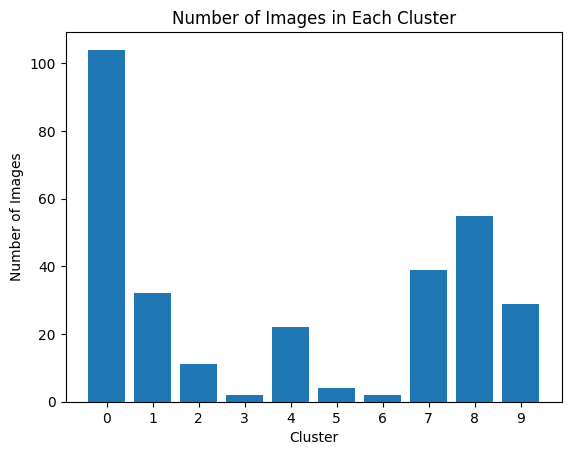

104 32 11 2 22 4 2 39 55 29


In [86]:
import matplotlib.pyplot as plt

cluster_sizes = [len(clustered_images[i]) for i in range(clusters)]

plt.bar(range(clusters), cluster_sizes, tick_label=range(clusters))
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Cluster')
plt.show()
print(*cluster_sizes)

In [87]:
# Getting MAP values for each class
map_values = {}

for classname in class_names:
    map_values[classname] = calculate_map(classname, ranked_lists)

for key, value in map_values.items():
    print(f'MAP for class {key}:\t {value}')

MAP for class airplane:	 0.14964285714285713
MAP for class bear:	 0.23600198412698412
MAP for class blimp:	 0.05927083333333333
MAP for class bonsai:	 0.33613095238095236
MAP for class cactus:	 0.2540376984126984
MAP for class dog:	 0.2130952380952381
MAP for class goat:	 0.2178720238095238
MAP for class googse:	 0.14317460317460318
MAP for class ibis:	 0.1581547619047619
MAP for class iris:	 0.257172619047619


# PART 3: Classification with Logistic Regression

In [88]:
# Defining functions for logistic regression 
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def hypothesis(X, theta):
    return sigmoid(np.dot(X, theta))

def cost_function(X, y, theta):
    m = len(y)
    h = hypothesis(X, theta)
    cost = (-1 / m) * np.sum(y * np.log(h) + (1 - y) * np.log(1 - h))
    return cost

def gradient_descent(X, y, theta, learning_rate, iterations):
    m = len(y)
    costs = []

    for _ in range(iterations):
        h = hypothesis(X, theta)
        gradient = np.dot(X.T, (h - y)) / m
        theta -= learning_rate * gradient
        cost = cost_function(X, y, theta)
        costs.append(cost)

    return theta, costs

def predict(X, theta, threshold=0.5):
    probabilities = hypothesis(X, theta)
    predictions = (probabilities >= threshold).astype(int)
    return predictions




In [89]:
# Selecting two classes to classify
classes = {0: "bonsai", 1: "iris"}

image_features = []
image_filenames = []

query_features = []
query_filenames = []

y = []

# Opening the images of two classes we selected and query images, calculating their features
for folder in os.listdir("Dataset2"):
    if folder == classes[0] or folder == classes[1]:
        folder_path = os.path.join("Dataset2", folder)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(".jpg"):
                    if folder == classes[0]: y.append(0) 
                    else: y.append(1)
                    image_filenames.append([filename,folder])
                    image = Image.open(os.path.join(folder_path, filename)).convert("L")
                    image_features.append(color_histogram(image))
    if folder == "QUERY_IMAGES":
        folder_path = os.path.join("Dataset2", folder)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.startswith(classes[0]) or filename.startswith(classes[1]):
                    if filename.endswith(".jpg"):
                        query_filenames.append(filename)
                        image = Image.open(os.path.join(folder_path, filename))
                        query_features.append(color_histogram(image))

# Converting the data to numpy array
X = np.array(image_features) # (60,192)
y = np.array(y).reshape(-1, 1) # (60,1)
X_query = np.array(query_features) #(20,192)




In [90]:
from sklearn.metrics import accuracy_score

# Performing logistic regression and getting predictions
X = np.c_[np.ones((X.shape[0], 1)), X]
X_query = np.c_[np.ones((X_query.shape[0], 1)), X_query]

theta = np.zeros((X.shape[1], 1))

learning_rate = 0.01
iterations = 1000

theta, costs = gradient_descent(X, y, theta, learning_rate, iterations)

predictions = predict(X_query, theta)

y_true = np.array([0, 0, 1, 1]).reshape(-1, 1)


print("Predictions for Query Images:")
print(*predictions)
print(*y_true)

accuracy = accuracy_score(y_true, predictions)
print(f"Accuracy: {accuracy * 100}%")


Predictions for Query Images:
[0] [1] [1] [1]
[0] [0] [1] [1]
Accuracy: 75.0%


**BONUS PART: Classifying 10 classes with Logistic Regression**

In [91]:
# Defining functions for LR
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def cost_function(X, y, theta):
    m = len(y)
    h = sigmoid(X @ theta)
    cost = (-1 / m) * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))
    return cost

def gradient_descent(X, y, theta, learning_rate, iterations):
    m = len(y)
    costs = []

    for _ in range(iterations):
        gradient = (1 / m) * X.T @ (sigmoid(X @ theta) - y)
        theta = theta - learning_rate * gradient
        cost = cost_function(X, y, theta)
        costs.append(cost)

    return theta, costs

def predict(X, theta):
    predictions = sigmoid(X @ theta)
    return (predictions >= 0.5).astype(int)

In [92]:
# Keeping classes as integers in dictionary
classes = {0: "airplane", 1: "bear", 2: "blimp", 3: "bonsai", 4: "cactus", 5: "dog", 6: "goat", 7: "goose", 8: "ibis", 9: "iris"}

# Opening images, calculating their features and storing them
y = []
image_features = []
image_filenames = []

query_features = []
query_filenames = []
i = 0
for folder in os.listdir("Dataset2"):
    if folder != "QUERY_IMAGES":
        folder_path = os.path.join("Dataset2", folder)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                y.append(i)
                if filename.endswith(".jpg"):
                    image_filenames.append([filename,folder])
                    image = Image.open(os.path.join(folder_path, filename)).convert("L")
                    image_features.append(color_histogram(image))
    if folder == "QUERY_IMAGES":
        folder_path = os.path.join("Dataset2", folder)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                    if filename.endswith(".jpg"):
                        query_filenames.append(filename)
                        image = Image.open(os.path.join(folder_path, filename))
                        query_features.append(color_histogram(image))
    i += 1

In [93]:
X = np.array(image_features)
y = np.array(y).reshape(-1,1)
X_query = np.array(query_features)
y_test = np.array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9])


X = np.c_[np.ones((X.shape[0], 1)), X]
X_query = np.c_[np.ones((X_query.shape[0], 1)), X_query]

theta_matrix = np.zeros((X.shape[1], len(classes)))

learning_rate = 0.01
iterations = 10000

# Training a binary logistic regression classifier for each class
for i in range(len(classes)):
    binary_labels = (y == i).astype(int)
    theta = np.zeros((X.shape[1], 1))
    theta, costs = gradient_descent(X, binary_labels, theta, learning_rate, iterations)
    theta_matrix[:, i:i+1] = theta

# Making predictions
predictions_matrix = predict(X_query, theta_matrix)

# Choosing the class with the highest probability
final_predictions = np.argmax(predictions_matrix, axis=1)

print("Predictions for Query Images:")
print(*final_predictions)
print(*y_test)
print(f"Accuracy: {accuracy_score(y_test, final_predictions) * 100}%")


Predictions for Query Images:
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
0 0 1 1 2 2 3 3 4 4 5 5 6 6 7 7 8 8 9 9
Accuracy: 10.0%
